In [81]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [82]:
env = gym.make("CartPole-v1")

In [83]:
env.reset() # returns a tuple with (obs, info)

(array([-0.00473719,  0.04379356, -0.01379597,  0.00268458], dtype=float32),
 {})

In [84]:
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()

        self.policy_net = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.policy_net(x)

In [85]:
def select_action(policy, state):
    # Return action and log prob of that action

    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    probs = policy(state)
    dist = torch.distributions.Categorical(probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)

In [86]:
policy_net = Policy(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

In [87]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

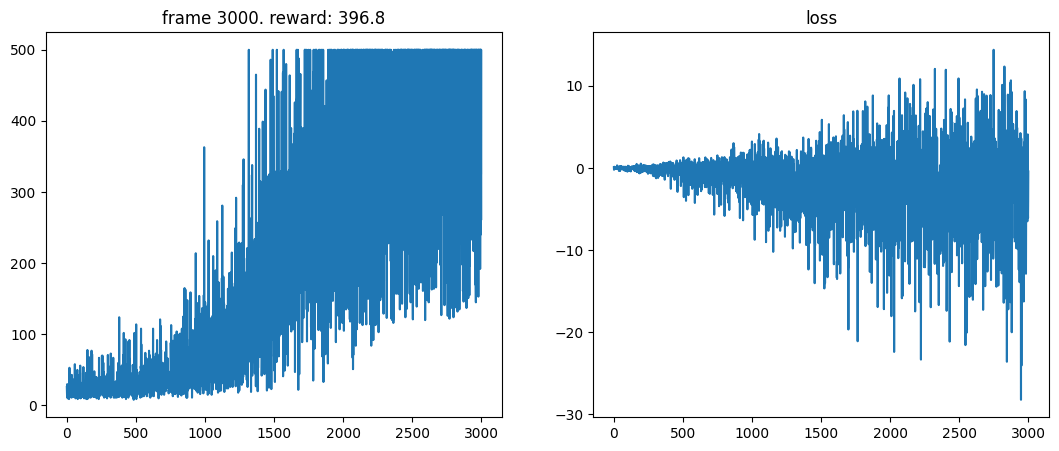

In [88]:
num_episodes = 3_000
gamma = 0.99
episode_rewards = []
losses = []


for episode in range(1, num_episodes + 1):
    log_probs = []
    rewards = []

    state, _ = env.reset()
    done = False

    while not done:

        action, log_prob = select_action(policy_net, state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        log_probs.append(log_prob)
        rewards.append(reward)

        state = next_state
    
    # Compute the reward to go
    rewards = torch.tensor(rewards, dtype=torch.float32)
    returns = torch.zeros_like(rewards)

    G = 0
    for t in reversed(range(len(rewards))):
        G = rewards[t] + gamma * G
        returns[t] = G
    
    # Normalize returns
    returns = (returns - returns.mean()) / (returns.std() + 1e-10)

    policy_loss = []
    for log_prob, Gt in zip(log_probs, returns):
        policy_loss.append(-log_prob * Gt)
    policy_loss = torch.cat(policy_loss).sum()

    losses.append(policy_loss.item())

    # Update Policy Network

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    episode_rewards.append(sum(rewards))

    if (episode % 100) == 0:
        plot(episode, episode_rewards, losses)

